In [32]:
%pip install pydub
%pip install librosa
%pip install os-sys  
%pip install librosa
%pip install matplotlib
%pip install numpy
%pip install tensorflow
%pip install keras
%pip install pydub
%pip install scikit-learn
%pip install visualkeras

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached os_sys-2.1.4-py3-none-any.whl.metadata (9.9 kB)
  Using cached pygubu-0.38.2-py3-none-any.whl.metadata (7.3 kB)
  Using cached sqlparse-0.5.3-py3-none-any.whl.metadata (3.9 kB)
  Using cached progress-1.6.1-py3-none-any.whl.metadata (4.3 kB)
  Using cached progressbar-2.5.tar.gz (10 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached eel-0.18.2.tar.gz (26 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached extract_zip-1.0.0-py3-none-any.whl.metadata (403 bytes)
INFO: pip is looking at multiple versions of os-sys to determine which version is compatible with other requirements. This could take a while.
  Using cached os_sys-2.1.3-py3-none-any.whl.metadata (9.9 kB)
  Using cached os_sys-2.1.2-py3-none-any.wh

ERROR: os-sys has an invalid wheel, os-sys has an invalid wheel, could not read 'os_sys-1.9.3.dist-info/WHEEL' file: KeyError("There is no item named 'os_sys-1.9.3.dist-info/WHEEL' in the archive")


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [33]:
import os
import librosa, librosa.display
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
from keras import models
from keras import layers
import pydub
from pydub import AudioSegment
from pydub.utils import which
AudioSegment.converter = which("ffmpeg")
AudioSegment.ffprobe = which("ffprobe")
import math
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import save_model
import visualkeras
from PIL import ImageFont
from PIL import ImageDraw
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
src_dir = '../dataset/'
dst_dir = '../dataset_wav'
print(os.listdir(src_dir))
# print(os.listdir(dst_dir))

['Ardhito Pramono_Dancing In September.mp3', 'Ed Sheeran_Supermarket Flowers.mp3', 'GANGGA_Whiskey Bottle.mp3', 'Giveon_Heartbreak Anniversary.mp3', 'Gracie Abrams_That’s So True.mp3', 'Keshi_UNDERSTAND.mp3', 'Labrinth_Jealous.mp3', 'Lady Gaga_Die With A Smile.mp3', 'Lauv_First Heartbreak.mp3', 'Lukas Graham_Love Someone.mp3', 'Rich Brian_100 Degrees.mp3', 'Ricky Montgomery_This December.mp3']
['Ardhito Pramono_Dancing In September', 'Ed Sheeran_Supermarket Flowers', 'GANGGA_Whiskey Bottle', 'Giveon_Heartbreak Anniversary', 'Gracie Abrams_That’s So True', 'Keshi_UNDERSTAND', 'Labrinth_Jealous', 'Lady Gaga_Die With A Smile', 'Lauv_First Heartbreak', 'Lukas Graham_Love Someone', 'Rich Brian_100 Degrees', 'Ricky Montgomery_This December']


In [ ]:
SAMPLE_RATE = 22050
N_MFCC = 13
N_FFT = 2048
HOP_LENGTH = 512
NUM_SEGMENTS = 10
file_list = []

def convert_mp3_to_wav(src_dir, dst_dir):
    if not os.path.exists(dst_dir):
        os.makedirs(dst_dir)
        labels = set()

        for file_name in os.listdir(src_dir):
            if file_name.endswith('.mp3'):
                sub_dir = os.path.join(dst_dir, file_name.replace('.mp3', ''))
                if not os.path.exists(sub_dir):
                    os.makedirs(sub_dir)

                mp3_path = os.path.join(src_dir, file_name)
                wav_path = os.path.join(sub_dir, file_name.replace('.mp3', '.wav'))

                try:
                    audio = AudioSegment.from_mp3(mp3_path)
                    audio.export(wav_path, format='wav')
                    # print(f"Converted {mp3_path} to {wav_path}")
                    file_list.append(wav_path)
                    
                    if "_" in file_name:
                        artist, song = file_name.replace('.mp3', '').split("_", 1)
                        label = f"{artist} - {song}"
                        labels.add(label)  
                except Exception as e:
                    print(f"Failed to convert {mp3_path}: {e}")

        with open('labels.txt', 'w') as f:
            for label in labels: 
                f.write(label + "\n")
    else:
        print(f"{dst_dir} already exists, skipping...")   

def crop_wav(wav_dir, segment_duration=5000, num_segments_per_file=NUM_SEGMENTS):
    for root, _, files in os.walk(wav_dir):
        for file_name in files:
            if file_name.endswith('.wav') and '_segment_' not in file_name:  # Only process original files
                wav_path = os.path.join(root, file_name)
                
                base_name = file_name.replace('.wav', '')
                segments_exist = any(f.startswith(f"{base_name}_segment_") and f.endswith('.wav') 
                                   for f in files)
                
                if segments_exist:
                    print(f"Segments already exist for {file_name}, skipping...")
                    continue
                
                try:
                    audio = AudioSegment.from_wav(wav_path)
                    audio_length = len(audio)

                    if audio_length < segment_duration:
                        print(f"Audio {file_name} is too short ({audio_length}ms) for {segment_duration}ms segments")
                        continue

                    for i in range(num_segments_per_file):
                        start = random.randint(0, audio_length - segment_duration)
                        end = start + segment_duration
                        segment = audio[start:end]

                        segment_file_name = f"{base_name}_segment_{i}.wav"
                        segment_path = os.path.join(root, segment_file_name)
                        segment.export(segment_path, format='wav')
                        print(f"Created segment: {segment_file_name}")
                        
                except Exception as e:
                    print(f"Failed to crop {wav_path}: {e}")

convert_mp3_to_wav(src_dir, dst_dir)
crop_wav(dst_dir)

../dataset_wav already exists, skipping conversion.
Segments already exist for Ardhito Pramono_Dancing In September.wav, skipping...
Segments already exist for Ed Sheeran_Supermarket Flowers.wav, skipping...
Segments already exist for GANGGA_Whiskey Bottle.wav, skipping...
Segments already exist for Giveon_Heartbreak Anniversary.wav, skipping...
Segments already exist for Gracie Abrams_That’s So True.wav, skipping...
Segments already exist for Keshi_UNDERSTAND.wav, skipping...
Segments already exist for Labrinth_Jealous.wav, skipping...
Segments already exist for Lady Gaga_Die With A Smile.wav, skipping...
Segments already exist for Lauv_First Heartbreak.wav, skipping...
Segments already exist for Lukas Graham_Love Someone.wav, skipping...
Segments already exist for Rich Brian_100 Degrees.wav, skipping...
Segments already exist for Ricky Montgomery_This December.wav, skipping...


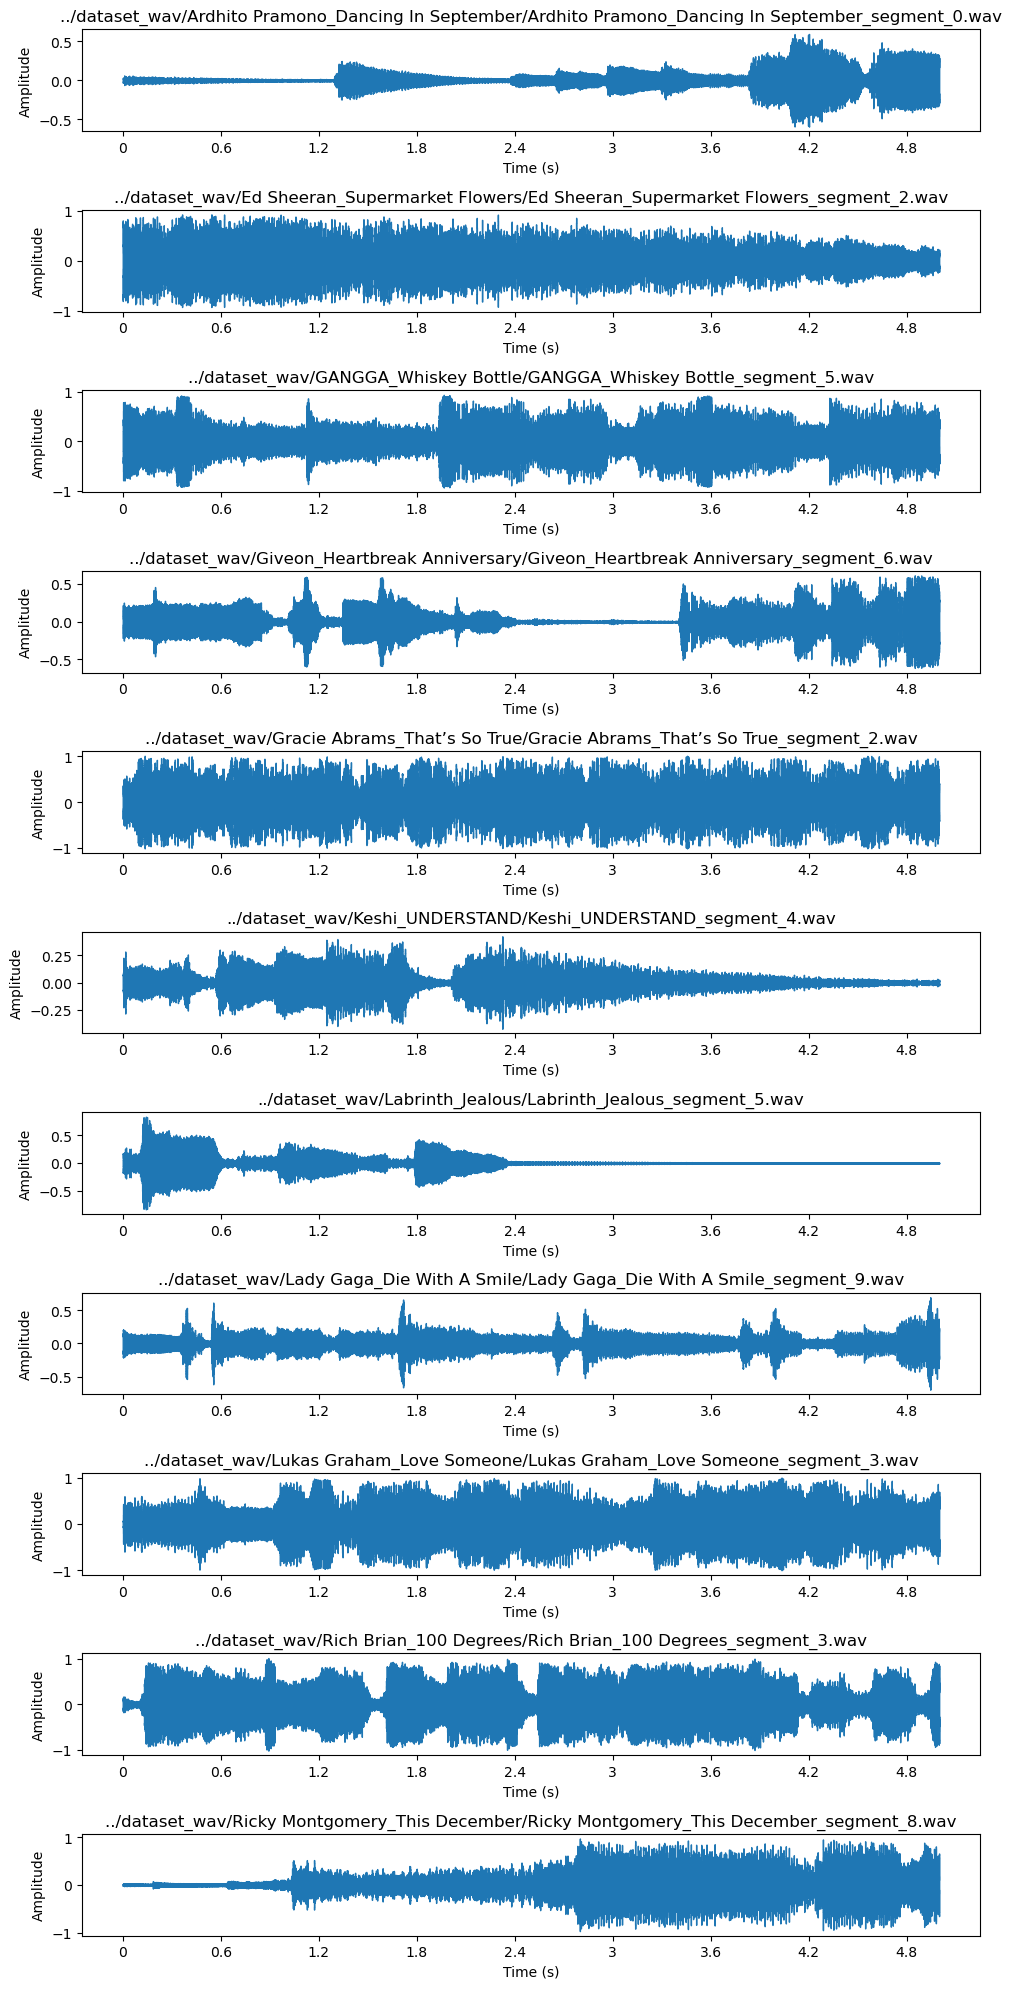

In [36]:
SAMPLE_RATE = 22050
files = [
    "../dataset_wav/Ardhito Pramono_Dancing In September/Ardhito Pramono_Dancing In September_segment_0.wav",
    "../dataset_wav/Ed Sheeran_Supermarket Flowers/Ed Sheeran_Supermarket Flowers_segment_2.wav",
    "../dataset_wav/GANGGA_Whiskey Bottle/GANGGA_Whiskey Bottle_segment_5.wav",
    "../dataset_wav/Giveon_Heartbreak Anniversary/Giveon_Heartbreak Anniversary_segment_6.wav",
    "../dataset_wav/Gracie Abrams_That’s So True/Gracie Abrams_That’s So True_segment_2.wav",
    "../dataset_wav/Keshi_UNDERSTAND/Keshi_UNDERSTAND_segment_4.wav",
    "../dataset_wav/Labrinth_Jealous/Labrinth_Jealous_segment_5.wav",
    "../dataset_wav/Lady Gaga_Die With A Smile/Lady Gaga_Die With A Smile_segment_9.wav",
    "../dataset_wav/Lukas Graham_Love Someone/Lukas Graham_Love Someone_segment_3.wav",
    "../dataset_wav/Rich Brian_100 Degrees/Rich Brian_100 Degrees_segment_3.wav",
    "../dataset_wav/Ricky Montgomery_This December/Ricky Montgomery_This December_segment_8.wav"
]

fig, axes = plt.subplots(nrows=len(files), figsize=(10, 20))

for i, file_path in enumerate(files):
    signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    axes[i].set_title(file_path)
    librosa.display.waveshow(signal, sr=sr, ax=axes[i])
    axes[i].set_xlabel("Time (s)")
    axes[i].set_ylabel("Amplitude")

plt.tight_layout()
plt.show()


In [37]:
import random
def augment_audio(signal, sr):

    rate = random.uniform(0.8, 1.2)
    stretched_signal = librosa.effects.time_stretch(signal, rate=rate)

    steps = random.randint(-5, 5)
    shifted_signal = librosa.effects.pitch_shift(signal, sr=sr,n_steps=steps)

    noise_factor = 0.005
    noise = np.random.randn(len(signal))
    noisy_signal = signal + noise_factor * noise

    return [stretched_signal, shifted_signal, noisy_signal]

In [38]:
DATASET_PATH = "../dataset_wav"

num_samples_per_segment = int(SAMPLE_RATE * 5 / NUM_SEGMENTS)
expected = math.ceil(num_samples_per_segment / HOP_LENGTH)

def mfcc(data_set):
    features = []
    labels = []

    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(data_set)):
        if dirpath != data_set:
            label = dirpath.split("/")[-1]
            print("\nProcessing {}".format(label))

            for filename in filenames:
                file_path = os.path.join(dirpath, filename)
                signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)

                for s in range(NUM_SEGMENTS):
                    start_sample = num_samples_per_segment * s
                    finish_sample = start_sample + num_samples_per_segment

                    mfcc = librosa.feature.mfcc(y=signal[start_sample:finish_sample], sr=SAMPLE_RATE, n_mfcc=N_MFCC, n_fft=N_FFT, hop_length=HOP_LENGTH)
                    mfcc = mfcc.T

                    if len(mfcc) == expected:
                        features.append(mfcc.tolist())
                        labels.append(label)
                        print("{}, segment:{}".format(file_path, s + 1))

                augmented_signals = augment_audio(signal, sr=SAMPLE_RATE)
                for augmented_signal in augmented_signals:
                    for s in range(NUM_SEGMENTS):
                        start_sample = num_samples_per_segment * s
                        finish_sample = start_sample + num_samples_per_segment

                        mfcc = librosa.feature.mfcc(y=augmented_signal[start_sample:finish_sample], sr=sr, n_mfcc=N_MFCC, n_fft=N_FFT, hop_length=HOP_LENGTH)
                        mfcc = mfcc.T

                        if len(mfcc) == expected:
                            features.append(mfcc.tolist())
                            labels.append(label)
                            print("Augmented, {}, segment:{}".format(file_path, s + 1))

    return np.array(features), np.array(labels)

mfccs, labels = mfcc(DATASET_PATH)



Processing dataset_wav\Ardhito Pramono_Dancing In September
../dataset_wav\Ardhito Pramono_Dancing In September\Ardhito Pramono_Dancing In September.wav, segment:1
../dataset_wav\Ardhito Pramono_Dancing In September\Ardhito Pramono_Dancing In September.wav, segment:2
../dataset_wav\Ardhito Pramono_Dancing In September\Ardhito Pramono_Dancing In September.wav, segment:3
../dataset_wav\Ardhito Pramono_Dancing In September\Ardhito Pramono_Dancing In September.wav, segment:4
../dataset_wav\Ardhito Pramono_Dancing In September\Ardhito Pramono_Dancing In September.wav, segment:5
../dataset_wav\Ardhito Pramono_Dancing In September\Ardhito Pramono_Dancing In September.wav, segment:6
../dataset_wav\Ardhito Pramono_Dancing In September\Ardhito Pramono_Dancing In September.wav, segment:7
../dataset_wav\Ardhito Pramono_Dancing In September\Ardhito Pramono_Dancing In September.wav, segment:8
../dataset_wav\Ardhito Pramono_Dancing In September\Ardhito Pramono_Dancing In September.wav, segment:9
../

c:\Users\Aryo Baskoro\anaconda3\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(


Augmented, ../dataset_wav\Ardhito Pramono_Dancing In September\Ardhito Pramono_Dancing In September_segment_0.wav, segment:5
Augmented, ../dataset_wav\Ardhito Pramono_Dancing In September\Ardhito Pramono_Dancing In September_segment_0.wav, segment:6
Augmented, ../dataset_wav\Ardhito Pramono_Dancing In September\Ardhito Pramono_Dancing In September_segment_0.wav, segment:7
Augmented, ../dataset_wav\Ardhito Pramono_Dancing In September\Ardhito Pramono_Dancing In September_segment_0.wav, segment:8
Augmented, ../dataset_wav\Ardhito Pramono_Dancing In September\Ardhito Pramono_Dancing In September_segment_0.wav, segment:9
Augmented, ../dataset_wav\Ardhito Pramono_Dancing In September\Ardhito Pramono_Dancing In September_segment_0.wav, segment:10
../dataset_wav\Ardhito Pramono_Dancing In September\Ardhito Pramono_Dancing In September_segment_1.wav, segment:1
../dataset_wav\Ardhito Pramono_Dancing In September\Ardhito Pramono_Dancing In September_segment_1.wav, segment:2
../dataset_wav\Ardhit

c:\Users\Aryo Baskoro\anaconda3\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=258
  warnings.warn(


Augmented, ../dataset_wav\Ardhito Pramono_Dancing In September\Ardhito Pramono_Dancing In September_segment_4.wav, segment:6
Augmented, ../dataset_wav\Ardhito Pramono_Dancing In September\Ardhito Pramono_Dancing In September_segment_4.wav, segment:7
Augmented, ../dataset_wav\Ardhito Pramono_Dancing In September\Ardhito Pramono_Dancing In September_segment_4.wav, segment:8
Augmented, ../dataset_wav\Ardhito Pramono_Dancing In September\Ardhito Pramono_Dancing In September_segment_4.wav, segment:9
Augmented, ../dataset_wav\Ardhito Pramono_Dancing In September\Ardhito Pramono_Dancing In September_segment_4.wav, segment:10
../dataset_wav\Ardhito Pramono_Dancing In September\Ardhito Pramono_Dancing In September_segment_5.wav, segment:1
../dataset_wav\Ardhito Pramono_Dancing In September\Ardhito Pramono_Dancing In September_segment_5.wav, segment:2
../dataset_wav\Ardhito Pramono_Dancing In September\Ardhito Pramono_Dancing In September_segment_5.wav, segment:3
../dataset_wav\Ardhito Pramono_D

c:\Users\Aryo Baskoro\anaconda3\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1080
  warnings.warn(


Augmented, ../dataset_wav\GANGGA_Whiskey Bottle\GANGGA_Whiskey Bottle_segment_3.wav, segment:1
Augmented, ../dataset_wav\GANGGA_Whiskey Bottle\GANGGA_Whiskey Bottle_segment_3.wav, segment:2
Augmented, ../dataset_wav\GANGGA_Whiskey Bottle\GANGGA_Whiskey Bottle_segment_3.wav, segment:3
Augmented, ../dataset_wav\GANGGA_Whiskey Bottle\GANGGA_Whiskey Bottle_segment_3.wav, segment:4
Augmented, ../dataset_wav\GANGGA_Whiskey Bottle\GANGGA_Whiskey Bottle_segment_3.wav, segment:5
Augmented, ../dataset_wav\GANGGA_Whiskey Bottle\GANGGA_Whiskey Bottle_segment_3.wav, segment:6
Augmented, ../dataset_wav\GANGGA_Whiskey Bottle\GANGGA_Whiskey Bottle_segment_3.wav, segment:7
Augmented, ../dataset_wav\GANGGA_Whiskey Bottle\GANGGA_Whiskey Bottle_segment_3.wav, segment:8
Augmented, ../dataset_wav\GANGGA_Whiskey Bottle\GANGGA_Whiskey Bottle_segment_3.wav, segment:9
Augmented, ../dataset_wav\GANGGA_Whiskey Bottle\GANGGA_Whiskey Bottle_segment_3.wav, segment:1
Augmented, ../dataset_wav\GANGGA_Whiskey Bottle\GA

c:\Users\Aryo Baskoro\anaconda3\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2004
  warnings.warn(


../dataset_wav\Keshi_UNDERSTAND\Keshi_UNDERSTAND_segment_6.wav, segment:7
../dataset_wav\Keshi_UNDERSTAND\Keshi_UNDERSTAND_segment_6.wav, segment:8
../dataset_wav\Keshi_UNDERSTAND\Keshi_UNDERSTAND_segment_6.wav, segment:9
../dataset_wav\Keshi_UNDERSTAND\Keshi_UNDERSTAND_segment_6.wav, segment:10
Augmented, ../dataset_wav\Keshi_UNDERSTAND\Keshi_UNDERSTAND_segment_6.wav, segment:1
Augmented, ../dataset_wav\Keshi_UNDERSTAND\Keshi_UNDERSTAND_segment_6.wav, segment:2
Augmented, ../dataset_wav\Keshi_UNDERSTAND\Keshi_UNDERSTAND_segment_6.wav, segment:3
Augmented, ../dataset_wav\Keshi_UNDERSTAND\Keshi_UNDERSTAND_segment_6.wav, segment:4
Augmented, ../dataset_wav\Keshi_UNDERSTAND\Keshi_UNDERSTAND_segment_6.wav, segment:5
Augmented, ../dataset_wav\Keshi_UNDERSTAND\Keshi_UNDERSTAND_segment_6.wav, segment:6
Augmented, ../dataset_wav\Keshi_UNDERSTAND\Keshi_UNDERSTAND_segment_6.wav, segment:7
Augmented, ../dataset_wav\Keshi_UNDERSTAND\Keshi_UNDERSTAND_segment_6.wav, segment:8
Augmented, ../dataset_w

c:\Users\Aryo Baskoro\anaconda3\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=459
  warnings.warn(


Augmented, ../dataset_wav\Lady Gaga_Die With A Smile\Lady Gaga_Die With A Smile_segment_7.wav, segment:1
Augmented, ../dataset_wav\Lady Gaga_Die With A Smile\Lady Gaga_Die With A Smile_segment_7.wav, segment:2
Augmented, ../dataset_wav\Lady Gaga_Die With A Smile\Lady Gaga_Die With A Smile_segment_7.wav, segment:3
Augmented, ../dataset_wav\Lady Gaga_Die With A Smile\Lady Gaga_Die With A Smile_segment_7.wav, segment:4
Augmented, ../dataset_wav\Lady Gaga_Die With A Smile\Lady Gaga_Die With A Smile_segment_7.wav, segment:5
Augmented, ../dataset_wav\Lady Gaga_Die With A Smile\Lady Gaga_Die With A Smile_segment_7.wav, segment:6
Augmented, ../dataset_wav\Lady Gaga_Die With A Smile\Lady Gaga_Die With A Smile_segment_7.wav, segment:7
Augmented, ../dataset_wav\Lady Gaga_Die With A Smile\Lady Gaga_Die With A Smile_segment_7.wav, segment:8
Augmented, ../dataset_wav\Lady Gaga_Die With A Smile\Lady Gaga_Die With A Smile_segment_7.wav, segment:9
Augmented, ../dataset_wav\Lady Gaga_Die With A Smile\La

c:\Users\Aryo Baskoro\anaconda3\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1
  warnings.warn(


Augmented, ../dataset_wav\Lady Gaga_Die With A Smile\Lady Gaga_Die With A Smile_segment_9.wav, segment:6
Augmented, ../dataset_wav\Lady Gaga_Die With A Smile\Lady Gaga_Die With A Smile_segment_9.wav, segment:7
Augmented, ../dataset_wav\Lady Gaga_Die With A Smile\Lady Gaga_Die With A Smile_segment_9.wav, segment:8
Augmented, ../dataset_wav\Lady Gaga_Die With A Smile\Lady Gaga_Die With A Smile_segment_9.wav, segment:9
Augmented, ../dataset_wav\Lady Gaga_Die With A Smile\Lady Gaga_Die With A Smile_segment_9.wav, segment:10

Processing dataset_wav\Lauv_First Heartbreak
../dataset_wav\Lauv_First Heartbreak\Lauv_First Heartbreak.wav, segment:1
../dataset_wav\Lauv_First Heartbreak\Lauv_First Heartbreak.wav, segment:2
../dataset_wav\Lauv_First Heartbreak\Lauv_First Heartbreak.wav, segment:3
../dataset_wav\Lauv_First Heartbreak\Lauv_First Heartbreak.wav, segment:4
../dataset_wav\Lauv_First Heartbreak\Lauv_First Heartbreak.wav, segment:5
../dataset_wav\Lauv_First Heartbreak\Lauv_First Heartbreak

c:\Users\Aryo Baskoro\anaconda3\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1127
  warnings.warn(


Augmented, ../dataset_wav\Lauv_First Heartbreak\Lauv_First Heartbreak_segment_0.wav, segment:1
Augmented, ../dataset_wav\Lauv_First Heartbreak\Lauv_First Heartbreak_segment_0.wav, segment:2
Augmented, ../dataset_wav\Lauv_First Heartbreak\Lauv_First Heartbreak_segment_0.wav, segment:3
Augmented, ../dataset_wav\Lauv_First Heartbreak\Lauv_First Heartbreak_segment_0.wav, segment:4
Augmented, ../dataset_wav\Lauv_First Heartbreak\Lauv_First Heartbreak_segment_0.wav, segment:5
Augmented, ../dataset_wav\Lauv_First Heartbreak\Lauv_First Heartbreak_segment_0.wav, segment:6
Augmented, ../dataset_wav\Lauv_First Heartbreak\Lauv_First Heartbreak_segment_0.wav, segment:7
Augmented, ../dataset_wav\Lauv_First Heartbreak\Lauv_First Heartbreak_segment_0.wav, segment:8
Augmented, ../dataset_wav\Lauv_First Heartbreak\Lauv_First Heartbreak_segment_0.wav, segment:9
Augmented, ../dataset_wav\Lauv_First Heartbreak\Lauv_First Heartbreak_segment_0.wav, segment:10
Augmented, ../dataset_wav\Lauv_First Heartbreak\L

c:\Users\Aryo Baskoro\anaconda3\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1547
  warnings.warn(


Augmented, ../dataset_wav\Rich Brian_100 Degrees\Rich Brian_100 Degrees_segment_5.wav, segment:6
Augmented, ../dataset_wav\Rich Brian_100 Degrees\Rich Brian_100 Degrees_segment_5.wav, segment:7
Augmented, ../dataset_wav\Rich Brian_100 Degrees\Rich Brian_100 Degrees_segment_5.wav, segment:8
Augmented, ../dataset_wav\Rich Brian_100 Degrees\Rich Brian_100 Degrees_segment_5.wav, segment:9
Augmented, ../dataset_wav\Rich Brian_100 Degrees\Rich Brian_100 Degrees_segment_5.wav, segment:10
Augmented, ../dataset_wav\Rich Brian_100 Degrees\Rich Brian_100 Degrees_segment_5.wav, segment:1
Augmented, ../dataset_wav\Rich Brian_100 Degrees\Rich Brian_100 Degrees_segment_5.wav, segment:2
Augmented, ../dataset_wav\Rich Brian_100 Degrees\Rich Brian_100 Degrees_segment_5.wav, segment:3
Augmented, ../dataset_wav\Rich Brian_100 Degrees\Rich Brian_100 Degrees_segment_5.wav, segment:4
Augmented, ../dataset_wav\Rich Brian_100 Degrees\Rich Brian_100 Degrees_segment_5.wav, segment:5
Augmented, ../dataset_wav\Ric

c:\Users\Aryo Baskoro\anaconda3\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=729
  warnings.warn(


Augmented, ../dataset_wav\Rich Brian_100 Degrees\Rich Brian_100 Degrees_segment_9.wav, segment:1
Augmented, ../dataset_wav\Rich Brian_100 Degrees\Rich Brian_100 Degrees_segment_9.wav, segment:2
Augmented, ../dataset_wav\Rich Brian_100 Degrees\Rich Brian_100 Degrees_segment_9.wav, segment:3
Augmented, ../dataset_wav\Rich Brian_100 Degrees\Rich Brian_100 Degrees_segment_9.wav, segment:4
Augmented, ../dataset_wav\Rich Brian_100 Degrees\Rich Brian_100 Degrees_segment_9.wav, segment:5
Augmented, ../dataset_wav\Rich Brian_100 Degrees\Rich Brian_100 Degrees_segment_9.wav, segment:6
Augmented, ../dataset_wav\Rich Brian_100 Degrees\Rich Brian_100 Degrees_segment_9.wav, segment:7
Augmented, ../dataset_wav\Rich Brian_100 Degrees\Rich Brian_100 Degrees_segment_9.wav, segment:8
Augmented, ../dataset_wav\Rich Brian_100 Degrees\Rich Brian_100 Degrees_segment_9.wav, segment:9
Augmented, ../dataset_wav\Rich Brian_100 Degrees\Rich Brian_100 Degrees_segment_9.wav, segment:10
Augmented, ../dataset_wav\Ric

In [39]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

mfccs = mfccs[...,np.newaxis]

x_train,x_temp,y_train,y_temp = train_test_split(mfccs,labels,test_size = 0.4,random_state = 42,shuffle=True)
x_val,x_test,y_val,y_test = train_test_split(x_temp,y_temp,test_size = 0.5,random_state = 42,shuffle=True)

In [40]:
model = models.Sequential(
    [
        layers.Input(shape=(expected, N_MFCC, 1)),
        layers.Conv2D(filters=24, kernel_size=(5, 5), activation="relu"),
        layers.MaxPooling2D((4, 4), strides=(2, 2), padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(filters=48, kernel_size=(5, 5), activation="relu"),
        layers.MaxPooling2D((4, 4), strides=(2, 2), padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(filters=48, kernel_size=(5, 5), activation="relu", padding='same'),
        layers.MaxPooling2D((4, 4), strides=(2, 2), padding='same'),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(12, activation="softmax"),  
    ]
)

font = ImageFont.truetype("arial.ttf", 12)
img = visualkeras.layered_view(model, legend=True, font=font)  
img.save("model_visualization.png")
img.show()
model.summary()

c:\Users\Aryo Baskoro\anaconda3\Lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 18, 9, 24)      │           624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 5, 24)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 9, 5, 24)       │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 5, 1, 48)       │        28,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 3, 1, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 3, 1, 48)       │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 3, 1, 48)       │        57,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 1, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 2, 1, 48)       │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,588 (369.48 KB)

 Trainable params: 94,348 (368.55 KB)

 Non-trainable params: 240 (960.00 B)

In [41]:
print("Shape of x_train:", x_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of x_val:", x_val.shape)
print("Shape of y_val:", y_val.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of x_train: (3109, 22, 13, 1)
Shape of y_train: (3109,)
Shape of x_val: (1037, 22, 13, 1)
Shape of y_val: (1037,)
Shape of x_test: (1037, 22, 13, 1)
Shape of y_test: (1037,)


In [42]:
print(f"Unique labels in the dataset: {np.unique(labels)}")
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),loss="sparse_categorical_crossentropy",metrics=["accuracy"])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.00001, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=50,
    batch_size=32, 
    callbacks=[reduce_lr, early_stopping],
    verbose=1  
)

Unique labels in the dataset: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Epoch 1/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.1147 - loss: 2.7801 - val_accuracy: 0.1581 - val_loss: 2.3955 - learning_rate: 1.0000e-04
Epoch 2/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2736 - loss: 2.1390 - val_accuracy: 0.3414 - val_loss: 2.1105 - learning_rate: 1.0000e-04
Epoch 3/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3756 - loss: 1.8933 - val_accuracy: 0.4532 - val_loss: 1.8023 - learning_rate: 1.0000e-04
Epoch 4/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4349 - loss: 1.7316 - val_accuracy: 0.5333 - val_loss: 1.5707 - learning_rate: 1.0000e-04
Epoch 5/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4911 - loss: 1.5778 - val_accuracy: 0.5603 - val_loss: 1.4140 - learning_rate: 1.0000e-04
Epoch 6/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4909 - loss: 1.4949 - val_accuracy: 0.5844 - val_loss: 1.3280 - learning_rate: 1.0000e-04
Epoch 7/

In [43]:
score = model.evaluate(x_test,y_test)
print (f"Test Loss : {score[0]}")
print (f"Test Accuracy : {score[1]}")

y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
print("Predicted classes:", y_pred_classes)
print("True classes:", y_test)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8334 - loss: 0.5459 
Test Loss : 0.5974844694137573
Test Accuracy : 0.8158148527145386
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Predicted classes: [ 6 11  5 ...  3  2  7]
True classes: [ 6 11  5 ...  3  2 11]


Classification Report:
                                                  precision    recall  f1-score   support

dataset_wav\Ardhito Pramono_Dancing In September       0.92      0.68      0.78        97
      dataset_wav\Ed Sheeran_Supermarket Flowers       0.83      0.84      0.83        80
               dataset_wav\GANGGA_Whiskey Bottle       0.85      0.83      0.84        82
       dataset_wav\Giveon_Heartbreak Anniversary       0.72      0.85      0.78       100
        dataset_wav\Gracie Abrams_That’s So True       0.85      0.78      0.81        87
                    dataset_wav\Keshi_UNDERSTAND       0.85      0.92      0.88        91
                    dataset_wav\Labrinth_Jealous       0.82      0.69      0.75        81
          dataset_wav\Lady Gaga_Die With A Smile       0.78      0.81      0.80        80
               dataset_wav\Lauv_First Heartbreak       0.82      0.89      0.85        84
           dataset_wav\Lukas Graham_Love Someone       0.77      0.75      0

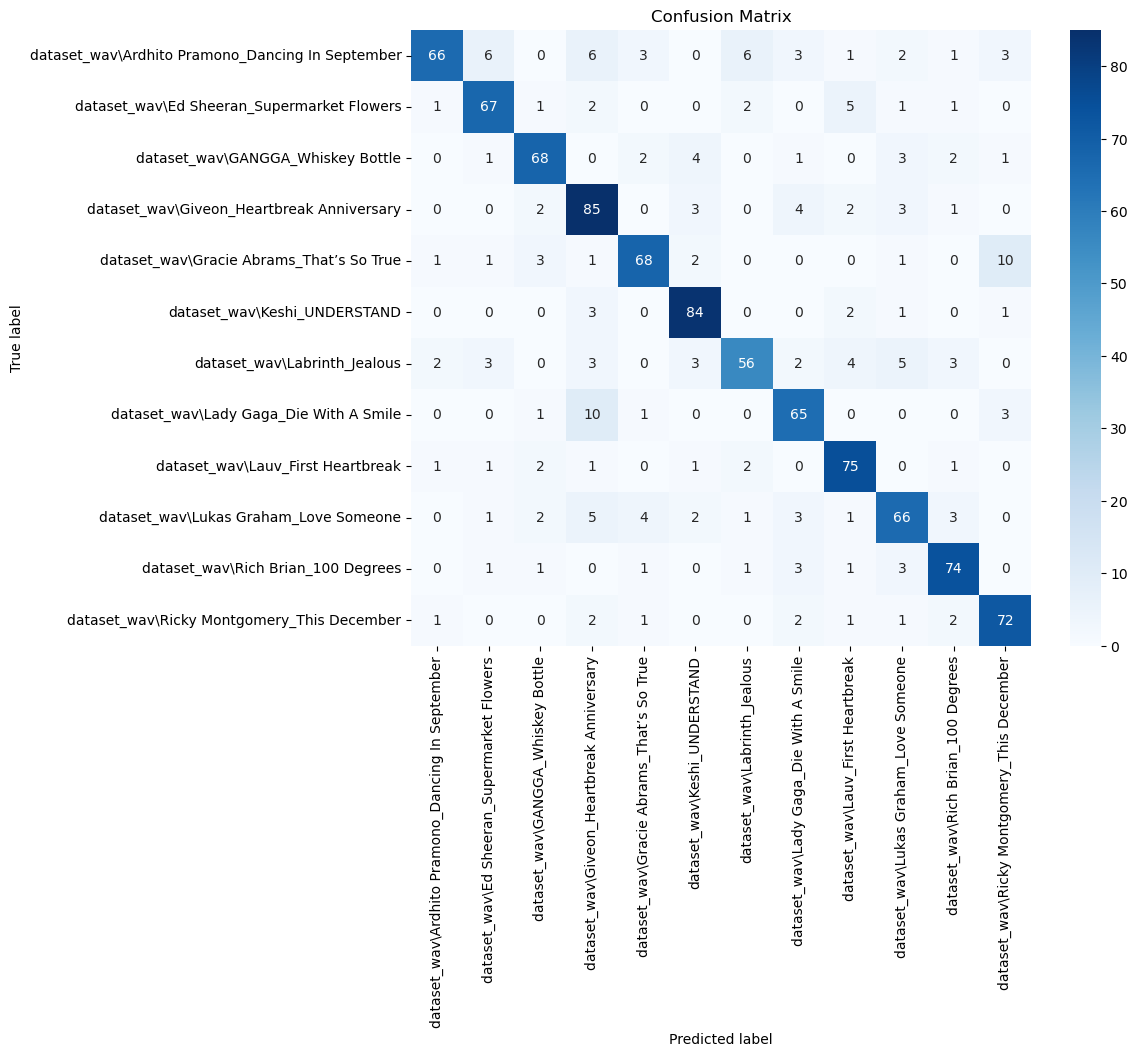

In [44]:
print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

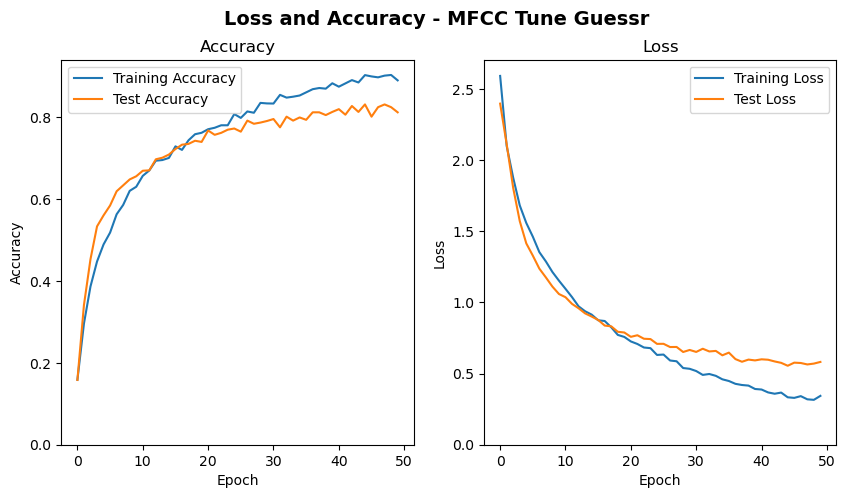

In [45]:
acc = history.history['accuracy']  
val_acc = history.history['val_accuracy'] 

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 5))
plt.suptitle("Loss and Accuracy - MFCC Tune Guessr", fontsize=14, fontweight='bold')  

plt.subplot(1, 2, 1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Test Accuracy")
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(bottom=0)

plt.subplot(1, 2, 2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Test Loss")
plt.legend()
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(bottom=0)
plt.savefig('mfcc_loss_accuracy.png')
plt.show()

In [46]:
import pickle
with open('/nice2.pkl','wb') as a:
    pickle.dump(model,a)

In [ ]:
from collections import Counter
label_to_song = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))

def predict_song(file_path):
    signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    num_segments = math.ceil(len(signal) / num_samples_per_segment)

    predictions = []

    for s in range(num_segments):
        start_sample = num_samples_per_segment * s
        end_sample = start_sample + num_samples_per_segment

        segment = signal[start_sample:end_sample]
        mfcc_features = librosa.feature.mfcc(
            y=segment, sr=SAMPLE_RATE, n_mfcc=N_MFCC, n_fft=N_FFT, hop_length=HOP_LENGTH
        )
        mfcc_features = mfcc_features.T[np.newaxis, ..., np.newaxis]

        prediction = model.predict(mfcc_features)
        predicted_label = np.argmax(prediction)
        predictions.append(predicted_label)

    most_common_label = Counter(predictions).most_common(1)[0][0]
    print(f"Predicted label: {most_common_label}")

    predicted_song = label_to_song[most_common_label]
    return predicted_song

In [48]:
new_file_path = "../dataset_wav/GANGGA_Whiskey Bottle/GANGGA_Whiskey Bottle_segment_5.wav"
predicted_song = predict_song(new_file_path)
path_parts = predicted_song.split("\\")[-1]  
artist, song = path_parts.split("_")  

print(f"Predicted Artist: {artist}")
print(f"Predicted Song: {song}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted label: 2
Predicted Artist: GANGGA
Predicted Song: Whiskey Bottle


In [49]:
model.save("model.keras")